# Lecture 3 - Neural network deep dive

> A deep dive into optimising neural networks with stochastic gradient descent

## Learning objectives

* Understand what stochastic gradient descent is and how to minimise functions with it in PyTorch
* Understand all the ingredients needed to define a `Learner` in fastai

## References

* Chapter 4 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [What is `torch.nn` really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html#what-is-torch-nn-really) by Jeremy Howard.

## Imports

In [1]:
import math

import torch
from datasets import load_dataset
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [2]:
import datasets

# Suppress logs to keep things tidy
datasets.logging.set_verbosity_error()

## The dataset

In lecture 2, we focused on optimising simple functions with stochastic gradient descent. Let's now tackle a real-world problem using neural networks! We'll use the $N$-subjettiness dataset from lecture 1 that represents jets in terms of $\tau_N^{(\beta)}$ variables that measure the radiation about $N$ axes in the jet according to an angular exponent $\beta>0$. As usual, we'll load the dataset from the Hugging Face Hub and convert it to a Pandas `DataFrame` via the `to_pandas()` method:

In [18]:
nsubjet_ds = load_dataset("dl4phys/top_tagging_nsubjettiness")
df = nsubjet_ds["train"].to_pandas()
df.head()

  0%|          | 0/3 [00:00<?, ?it/s]

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


### Preparing the data

In lecture 1, we used the `TabularDataLoaders.from_df()` method to quickly create dataloaders for the train and validation sets. In this lecture, we'll be working with PyTorch tensors directly, so we'll take a different approach. To get started, we'll need to split our data into a training and validation sets. We can do this quickly via the `train_test_split()` function from scikit-learn:

In [19]:
train_df, valid_df = train_test_split(df, random_state=42)
train_df.shape, valid_df.shape

((908250, 21), (302750, 21))

This has allocated 75% of our original dataset to `train_df` and the remainder to `valid_df`. Now that we have these `DataFrames`, the next thing we'll need are tensors for the features $(p_T, m, \tau_1^{(0.5)}, \tau_1^{(1)}, \tau_1^{(2)}, \ldots )$ and labels. There is, however, one potential problem: the jet $p_T$ and mass have much larger scales than the $N$-subjettiness $\tau_N^{(\beta)}$ features. We can see this by summarising the statistics of the training set with the `describe()` function: 

In [21]:
train_df.describe()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
count,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,...,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000,908250.000000
mean,487.107393,88.090520,0.366716,0.198446,0.319559,0.222759,0.079243,0.072535,0.148137,0.035372,...,0.112024,0.022150,0.008670,0.088400,0.015329,0.004875,0.070679,0.011019,0.002914,0.500366
std,48.568267,48.393646,0.186922,0.339542,2.003898,0.110955,0.125155,0.674091,0.072627,0.051869,...,0.059393,0.032004,0.155468,0.051949,0.022866,0.107641,0.046571,0.017133,0.078247,0.500000
min,225.490387,-0.433573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,452.879289,39.958178,0.224456,0.058381,0.006443,0.139269,0.025638,0.001565,0.094603,0.013308,...,0.069037,0.007949,0.000188,0.051012,0.004936,0.000079,0.036142,0.002977,0.000033,0.000000
50%,485.894050,99.887418,0.380172,0.166016,0.045887,0.222763,0.061597,0.008788,0.148810,0.028501,...,0.110220,0.017609,0.000787,0.086045,0.011755,0.000387,0.067797,0.008028,0.000193,1.000000
75%,520.506446,126.518545,0.477122,0.240550,0.074417,0.299708,0.108207,0.022441,0.196156,0.046588,...,0.151137,0.029990,0.002006,0.121905,0.021089,0.001103,0.100437,0.015359,0.000635,1.000000
max,647.493145,299.211555,2.431888,6.013309,37.702422,2.218956,5.392683,33.352249,1.917912,4.502011,...,1.616280,3.753716,21.161948,1.407356,3.158352,17.645603,1.388879,3.127371,17.340970,1.000000


As we saw in lecture 2, SGD can struggle to optimise the loss function when the feature scales are very different. To handle this, it is common to _normalize_ the features in some way. One way to do this is by rescaling all the features $x_i$ to lie in the interval $[0,1]$:

$$ x_i' = \frac{x_i - x_{i,\mathrm{min}}}{x_{i,\mathrm{max}} - x_{i,\mathrm{min}}} $$

To apply this normalization, let's first grab the NumPy arrays of the features and labels:

In [40]:
# Slice out all feature columns
train_x = train_df.iloc[:, :-1].values
# Slice out the label column
train_y = train_df.iloc[:, -1].values

Next, we use the `MinMaxScaler` from scikit-learn to apply the normalization on the features array:

In [41]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
# Sanity check the normalization worked
np.min(train_x), np.max(train_x)

(0.0, 1.0)

Great, this worked! Now that our features are all nicely normalised, let's convert these NumPy arrays to PyTorch tensors. PyTorch provides a handy `from_numpy()` method that allows us to do the conversion easily:

In [42]:
# Cast to float32
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_df.iloc[:, -1].values)
# Sanity check on the shapes
train_x.shape, train_y.shape

(torch.Size([908250, 20]), torch.Size([908250]))

Okay, now that we have our tensors it's time to train a neural network on the features!

## Logistic regression as a neural network

In [54]:
set_seed(42)
weights = torch.randn(20, 2) / math.sqrt(20)
weights.requires_grad_()
bias = torch.ones(2, requires_grad=True)

In [55]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)


def model(xb):
    return log_softmax(xb @ weights + bias)

In [56]:
bs = 1024  # batch size

xb = train_x[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape

(tensor([-0.5103, -0.9171], grad_fn=<SelectBackward0>), torch.Size([1024, 2]))

In [57]:
def nll(predictions, target):
    return -predictions[range(target.shape[0]), target].mean()


loss_func = nll

In [58]:
yb = train_y[0:bs]
print(loss_func(preds, yb))

tensor(0.7619, grad_fn=<NegBackward0>)


In [59]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [60]:
print(accuracy(preds, yb))

tensor(0.5020)


In [63]:
lr = 1e-2  # learning rate
epochs = 2  # how many epochs to train for
n = len(train_df)

for epoch in tqdm(range(epochs), desc="num_epochs"):
    for i in tqdm(range((n - 1) // bs + 1), leave=False):
        start_i = i * bs
        end_i = start_i + bs
        xb = train_x[start_i:end_i]
        yb = train_y[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

num_epochs:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/887 [00:00<?, ?it/s]

In [62]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.6026, grad_fn=<NegBackward0>) tensor(0.8519)


## Refactor using torch.nn.functional

In [88]:
import torch.nn.functional as F

loss_func = F.cross_entropy


def model(xb):
    return xb @ weights + bias

In [89]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.5866, grad_fn=<NllLossBackward0>) tensor(0.8570)


## Refactor using nn.Module

In [90]:
from torch import nn


class LogisticRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(20, 2) / math.sqrt(20))
        self.bias = nn.Parameter(torch.zeros(2))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [91]:
model = LogisticRegressor()

print(loss_func(model(xb), yb))

tensor(0.6916, grad_fn=<NllLossBackward0>)


In [92]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = train_x[start_i:end_i]
            yb = train_y[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()


fit()

In [93]:
print(loss_func(model(xb), yb))

tensor(0.5771, grad_fn=<NllLossBackward0>)


In [94]:
accuracy(model(xb), yb)

tensor(0.8560)

### Refactor using optim

In [95]:
from torch import optim

In [118]:
def get_model():
    model = LogisticRegressor()
    return model, optim.SGD(model.parameters(), lr=lr)


model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = train_x[start_i:end_i]
        yb = train_y[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.7049, grad_fn=<NllLossBackward0>)
tensor(0.5792, grad_fn=<NllLossBackward0>)


## Refactor using Dataset

In [119]:
from torch.utils.data import TensorDataset

In [120]:
train_ds = TensorDataset(train_x, train_y)

In [101]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.5940, grad_fn=<NllLossBackward0>)


### Refactor using DataLoader

In [103]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [104]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.5713, grad_fn=<NllLossBackward0>)


### Add validation

In [121]:
train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# Slice out all feature columns and cast to float32
valid_x = torch.from_numpy(scaler.fit_transform(valid_df.iloc[:, :-1].values)).float()
# Slice out the label column and convert to matrix of shape (num_examples, 1)
valid_y = torch.from_numpy(valid_df.iloc[:, -1].values)
valid_ds = TensorDataset(valid_x, valid_y)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [122]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.6379)
1 tensor(0.5772)


In [128]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    acc = accuracy(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), acc.item()

In [132]:
import numpy as np


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in tqdm(train_dl):
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums, accs = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = np.sum(np.multiply(accs, nums)) / np.sum(nums)

        print(epoch, val_loss, val_acc)

In [133]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [134]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/887 [00:00<?, ?it/s]

0 0.6251985956793674 0.8593955408599532


  0%|          | 0/887 [00:00<?, ?it/s]

1 0.5675691612205852 0.8616317094732768


## Going deeper

In [136]:
model = nn.Sequential(
    nn.Linear(20, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 2),
)
lr = 1e-3
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  0%|          | 0/887 [00:00<?, ?it/s]

0 0.6895127527026673 0.8562180017491788


  0%|          | 0/887 [00:00<?, ?it/s]

1 0.676258602224235 0.8750156895994254


## Fasti style

In [137]:
dls = DataLoaders(train_dl, valid_dl)

In [142]:
learn = Learner(dls, model, loss_func, opt_func=SGD, metrics=[accuracy])

SuggestedLRs(valley=0.010964781977236271)

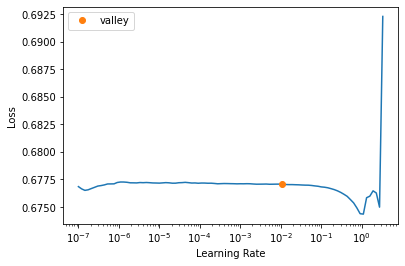

In [143]:
learn.lr_find()

In [144]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.611372,0.597583,0.869870,00:11
1,0.478586,0.475628,0.870259,00:11


## Exercises

* Use `nn.Module` to create the NN and train